In [1]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from adjustText import adjust_text

In [2]:
from nltk.stem import WordNetLemmatizer

In [3]:
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')

ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
ts_df = ts_df.loc[ts_df['count'] >= 50]

In [4]:
emotions = pd.read_csv('./data/emotions.csv')

In [5]:
lemmatizer = WordNetLemmatizer()

In [6]:
emotions =set(emotions.Word.unique())
emotion_words = set()
for w in emotions:
    word_lemma = lemmatizer.lemmatize(w.lower())
    emotion_words.add(word_lemma)


In [7]:
len(emotion_words)

537

In [8]:
morals = pd.read_csv('./data/mfd2.csv').word.unique()

moral_words = set()
for w in morals:
    word_lemma = lemmatizer.lemmatize(w.lower())
    moral_words.add(word_lemma)

In [9]:
len(emotion_words), len(moral_words)

(537, 1685)

In [10]:
intersection = emotion_words.intersection(moral_words)
len(intersection)


37

In [11]:
emotion_words = emotion_words - intersection
moral_words = moral_words - intersection

In [12]:
emotion_ts_df = ts_df[ts_df['words'].isin(emotion_words)]
moral_ts_df = ts_df[ts_df['words'].isin(moral_words)]
intersection_ts_df = ts_df[ts_df['words'].isin(intersection)]

In [13]:
len(intersection), len(emotion_words), len(moral_words)

(37, 500, 1648)

In [14]:
len(emotion_ts_df)

7438

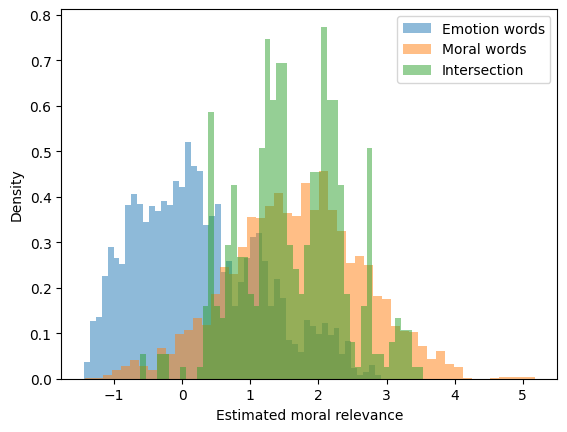

In [15]:
plt.hist(emotion_ts_df.loc[emotion_ts_df.property == 'previous_link'].outputs_z, bins=50, alpha=0.5, label='Emotion words',density=True)
plt.hist(moral_ts_df.loc[moral_ts_df.property == 'previous_link'].outputs_z, bins=50, alpha=0.5, label='Moral words',density=True)
plt.hist(intersection_ts_df.loc[intersection_ts_df.property == 'previous_link'].outputs_z, bins=50, alpha=0.5, label='Intersection',density=True)
plt.xlabel('Estimated moral relevance') 
plt.ylabel('Density')
plt.legend()
# plt.savefig('notebooks/figs/intersection_emotion_moral.png',dpi = 500)
plt.show()

In [16]:
import pingouin as pg

In [17]:
pg.ttest(emotion_ts_df.loc[emotion_ts_df.property == 'previous_link'].outputs_z,
          moral_ts_df.loc[moral_ts_df.property == 'previous_link'].outputs_z, #MFD words are more morally relevant than emotion words
          alternative='less')

/home/armzn/venv2/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-76.867253,7625.505394,less,0.0,"[-inf, -1.41]",1.498761,inf,1.0


In [18]:
#control for year

d1 = emotion_ts_df.loc[emotion_ts_df.property == 'previous_link']
d1_words = d1.words.unique()
control_words = set(moral_ts_df.loc[moral_ts_df.property == 'previous_link'].words.unique())
control_words = np.random.choice(list(control_words),len(d1_words),replace=False)
len(control_words), len(d1_words)
mapping = {d1_word:control_word for d1_word,control_word in zip(d1_words,control_words)}

In [19]:
len(d1)

3719

In [20]:
control_df = pd.DataFrame()
treatment_df = pd.DataFrame()
rows = []
for i, row in d1.iterrows():
    year = row['year']
    word = row['words']
    new_df = moral_ts_df.loc[(moral_ts_df.property == 'previous_link') & (moral_ts_df.year == year) & (moral_ts_df.words == mapping[word])]
    
    if len(new_df) > 0:
        control_df = pd.concat((control_df,new_df))
        rows.append(row)
treatment_df = pd.DataFrame(rows)
        

In [21]:
len(treatment_df), len(control_df)

(2702, 2702)

In [22]:
pg.ttest(treatment_df.outputs_z,
         control_df.outputs_z,
          alternative='less',
          paired=True
          ) #MFD words are more morally relevant than emotion words controlled for year

/home/armzn/venv2/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-54.828009,2701,less,0.0,"[-inf, -1.34]",1.488305,inf,1.0


Text(0, 0.5, 'Density')

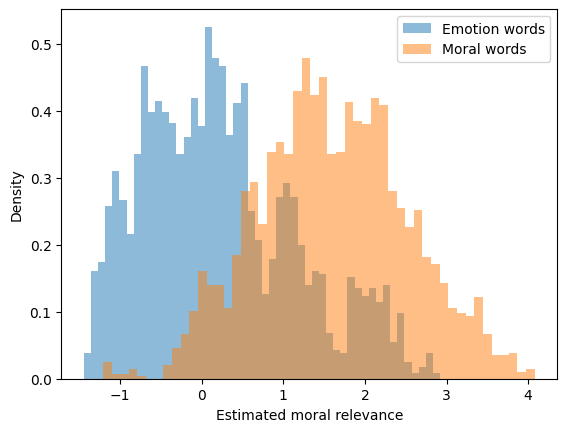

In [23]:
plt.hist(treatment_df.outputs_z, bins=50, alpha=0.5, label='Emotion words',density=True)
plt.hist(control_df.outputs_z, bins=50, alpha=0.5, label='Moral words',density=True)
plt.legend()
plt.xlabel('Estimated moral relevance')
plt.ylabel('Density')
# plt.savefig('notebooks/figs/intersection_emotion_moral_control.png',dpi = 500)